# Test idea

In [1]:
import torch 
import torch.nn as nn
from PIL import Image

from utils import describe_img
from vae import VAEncoder, VAEDecoder
from vcm import extract_style_emb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

/Users/hoangthuyduongvu/miniconda3/envs/tumor-analysis/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
IMAGE_PATH_SRC = "/Users/hoangthuyduongvu/Documents/icm/tumor-augmentation/data/HE/A3_TMA_15_02_IVB_HE.png"

IMAGE_PATH_DST = "/Users/hoangthuyduongvu/Documents/icm/tumor-augmentation/data/NKX3/A3_TMA_15_02_IB_NKX.png"

In [ ]:
describe_img(IMAGE_PATH_SRC)
describe_img(IMAGE_PATH_DST)

In [ ]:
print("Style Embedding Extraction:\n", extract_style_emb(IMAGE_PATH_SRC))
print("Style Embedding Extraction:\n", extract_style_emb(IMAGE_PATH_DST))

{'answer': ' The image presents a close-up view of a circular, pinkish-purple tissue sample. The tissue sample is composed of numerous small, dark pink/purple cells, which appear to be distributed throughout the circular shape. The cells are not uniformly distributed, with some areas showing a more dense concentration of cells. The background is a stark white, which contrasts with the pinkish-purple color of the tissue sample, making it stand out. The image does not contain any discernible text or additional objects, and the relative positions of the cells remain constant throughout the circular shape.'}
{'answer': ' The image presents a close-up view of a circular, white background with a blue and brown pattern. The pattern appears to be a microscopic view of a tissue sample, possibly a biopsy, with a complex network of blood vessels and capillaries. The blue areas are concentrated in the center, while the brown areas are more dispersed throughout the image. The pattern is not uniform

In [3]:
img = Image.open(IMAGE_PATH_SRC).resize((256, 256))

In [5]:
dec_res = decoder.forward(
    encoder.forward(
    torch.from_numpy(np.array(Image.open(IMAGE_PATH_SRC).resize((256, 256)))).float() \
    .unsqueeze(0).permute(0, 3, 1, 2)
    )
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-31.017012..29.190819].


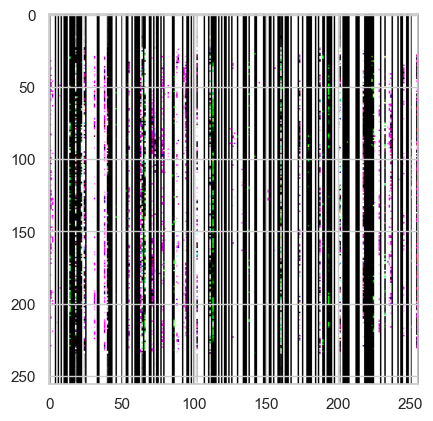

In [6]:
plt.imshow(
    dec_res.detach().numpy().squeeze().transpose(1, 2, 0)
)

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from PIL import Image

class VAEncoder(nn.Module):
    def __init__(self, input_dim=65536, latent_dim=128):  # Fixed input_dim
        super(VAEncoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, 4096)  # Increased hidden units
        self.fc2_mean = nn.Linear(4096, latent_dim)  # Mean for latent space
        self.fc2_logvar = nn.Linear(4096, latent_dim)  # Log variance for latent space

    def forward(self, x):
        x = F.relu(self.fc1(x))
        mean = self.fc2_mean(x)
        logvar = self.fc2_logvar(x)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)  # Convert log variance to standard deviation
        eps = torch.randn_like(std)  # Sample noise
        return mean + eps * std  # Reparameterization trick

class VAEDecoder(nn.Module):
    def __init__(self, latent_dim=128, output_dim=65536):  # Fixed output_dim
        super(VAEDecoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 4096)
        self.fc2 = nn.Linear(4096, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return torch.sigmoid(self.fc2(x))  # Sigmoid to normalize output

# Define loss function
def vae_loss(recon_x, x, mean, logvar):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
    return recon_loss + kl_divergence

In [12]:
# Initialize model
encoder = VAEncoder(input_dim=65536, latent_dim=128)
decoder = VAEDecoder(latent_dim=128, output_dim=65536)


# Example input image processing
img = Image.open(IMAGE_PATH_SRC).convert("L").resize((256, 256))  # Convert to grayscale, resize
img_tensor = torch.tensor(np.array(img) / 255.0, dtype=torch.float32).unsqueeze(0).view(1, -1)  # Flatten

# Forward pass
mean, logvar = encoder(img_tensor)
z = encoder.reparameterize(mean, logvar)
reconstructed = decoder(z)

# Compute loss
loss = vae_loss(reconstructed, img_tensor, mean, logvar)
print("Loss:", loss.item())

Loss: 10285.6953125


In [6]:
img_tensor.shape

torch.Size([1, 65536])

In [16]:
reconstructed_img = reconstructed.view(1, 256, 256).detach().numpy()

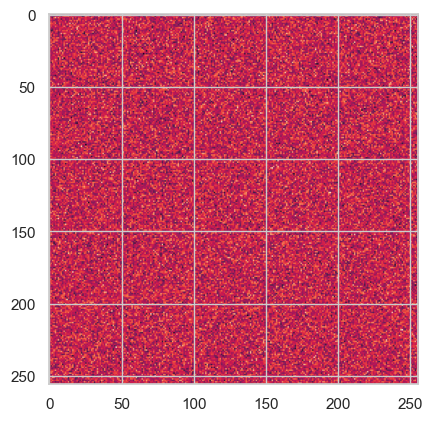

In [19]:
plt.imshow(reconstructed_img[0])

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from PIL import Image
from torch.utils.data import DataLoader, Dataset

class VAEncoder(nn.Module):
    def __init__(self, input_dim=65536, latent_dim=128):
        super(VAEncoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, 4096)
        self.fc2_mean = nn.Linear(4096, latent_dim)
        self.fc2_logvar = nn.Linear(4096, latent_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        mean = self.fc2_mean(x)
        logvar = self.fc2_logvar(x)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

class VAEDecoder(nn.Module):
    def __init__(self, latent_dim=128, output_dim=65536):
        super(VAEDecoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 4096)
        self.fc2 = nn.Linear(4096, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return torch.sigmoid(self.fc2(x))

# Define loss function
def vae_loss(recon_x, x, mean, logvar):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
    return recon_loss + kl_divergence

# Simple dataset class
class ImageDataset(Dataset):
    def __init__(self, image_paths):
        self.image_paths = image_paths
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("L").resize((256, 256))
        img_tensor = torch.tensor(np.array(img) / 255.0, dtype=torch.float32).view(-1)  # Flatten
        return img_tensor

# Training function
def train_vae(encoder, decoder, dataloader, epochs=10, lr=1e-3):
    optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=lr)
    encoder.train()
    decoder.train()
    
    for epoch in range(epochs):
        total_loss = 0
        for img_tensor in dataloader:
            img_tensor = img_tensor.to(torch.float32)
            mean, logvar = encoder(img_tensor)
            z = encoder.reparameterize(mean, logvar)
            reconstructed = decoder(z)
            
            loss = vae_loss(reconstructed, img_tensor, mean, logvar)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(dataloader)}")

# Initialize model
encoder = VAEncoder(input_dim=65536, latent_dim=128)
decoder = VAEDecoder(latent_dim=128, output_dim=65536)

# Example dataset (replace with actual image paths)
image_paths = ["/Users/hoangthuyduongvu/Documents/icm/tumor-augmentation/data/HE/A2_TMA_15_02_IVB_HE.png", "/Users/hoangthuyduongvu/Documents/icm/tumor-augmentation/data/HE/A3_TMA_15_02_IIB_HE.png"]  # Add real paths
dataset = ImageDataset(image_paths)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

# Train VAE
train_vae(encoder, decoder, dataloader, epochs=10, lr=1e-3)
